In [7]:
import os
import sys

# Set working directory
plant_clef_root = '/home/ffw/workspace/plantCLEF/'
os.chdir(plant_clef_root)

data_dir = os.path.join(plant_clef_root, 'data')

import numpy as np
import sklearn
import scipy
import scipy.misc
import time
import logging

import matplotlib.pyplot as plt
%matplotlib inline

from utilities import *
import mcl

import caffe
from caffe import layers as L
caffe.set_mode_gpu()

import mcl.nets.scatnet_net
reload(mcl.nets.scatnet_net)
from mcl.nets.scatnet_net import scatnet, gen_prototxt, get_layers_sizes


In [8]:
log_file_path = os.path.join(plant_clef_root, 'data', 'scattering.log')


logger = logging.getLogger('ScatnetTransform')
logger.setLevel(logging.INFO)

fh = logging.FileHandler(log_file_path)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s:%(levelname)s: %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

print log_file_path


/home/ffw/workspace/plantCLEF/data/scattering.log


# Instantiate network

In [9]:
reload(mcl.nets.scatnet_net)


scale = 3
scales = 2**np.arange(0,scale)
max_order = 3
nangles = 4
filter_size_factor = 2

In [10]:
path = gen_prototxt(data=L.Input(shape=dict(dim=[1, 3, 227, 227])),
              nchannels_input=3,
              scales=scales,
              max_order=max_order,
              nangles=nangles,
              filter_size_factor=filter_size_factor,)


#!cat $path

layer {
  name: "data"
  type: "Input"
  top: "data"
  input_param {
    shape {
      dim: 1
      dim: 3
      dim: 227
      dim: 227
    }
  }
}
layer {
  name: "scat1_0_3to12_real"
  type: "Convolution"
  bottom: "data"
  top: "Convolution1"
  convolution_param {
    num_output: 12
    pad: 0
    kernel_size: 4
    group: 3
    stride: 1
    weight_filler {
      type: "constant"
      value: 0
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name: "Power1"
  type: "Power"
  bottom: "Convolution1"
  top: "Convolution1"
  power_param {
    power: 2
  }
}
layer {
  name: "scat1_0_3to12_imag"
  type: "Convolution"
  bottom: "data"
  top: "Convolution2"
  convolution_param {
    num_output: 12
    pad: 0
    kernel_size: 4
    group: 3
    stride: 1
    weight_filler {
      type: "constant"
      value: 0
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name: "Power2"
  type: "Power"
  bottom: "Convolution2"
  top:

In [11]:
if 'net' in locals():
    del net
    
        
net = scatnet(data=L.Input(shape=dict(dim=[1, 3, 227, 227])),
              nchannels_input=3,
              scales=scales,
              max_order=max_order,
              nangles=nangles,
              filter_size_factor=filter_size_factor,)

In [34]:
for k in net.params.keys():
    print "%30s:"%k, net.params[k][0].data.shape

print "*"*50
print "Blobs"
print "*"*50
for k in net.blobs.keys():
    print "%30s:"%k, net.blobs[k].data.shape
    

            scat1_0_3to12_real: (12, 1, 4, 4)
            scat1_0_3to12_imag: (12, 1, 4, 4)
           scat2_3_12to48_real: (48, 1, 8, 8)
           scat2_3_12to48_imag: (48, 1, 8, 8)
          scat4_6_48to192_real: (192, 1, 16, 16)
          scat4_6_48to192_imag: (192, 1, 16, 16)
            scat2_1_3to12_real: (12, 1, 8, 8)
            scat2_1_3to12_imag: (12, 1, 8, 8)
            scat4_2_3to12_real: (12, 1, 16, 16)
            scat4_2_3to12_imag: (12, 1, 16, 16)
           scat4_4_12to48_real: (48, 1, 16, 16)
           scat4_4_12to48_imag: (48, 1, 16, 16)
           scat4_5_12to48_real: (48, 1, 16, 16)
           scat4_5_12to48_imag: (48, 1, 16, 16)
                           psi: (375, 1, 16, 16)
**************************************************
Blobs
**************************************************
                          data: (1, 3, 227, 227)
           data_data_0_split_0: (1, 3, 227, 227)
           data_data_0_split_1: (1, 3, 227, 227)
           data_data_0_split_2: (1

In [53]:
img = scipy.misc.imread('data/train/100025.jpg')[:600,:600,:]
img = scipy.misc.imresize(img,size=(227,227))
img = img.transpose(2,0,1)

img = img[:,:,:]
img_input = img[np.newaxis, ...].copy()


for _ in range(0):
    img_input = np.append(img_input, img_input, 0)

net.blobs['data'].reshape(*img_input.shape)
net.blobs['data'].data[...] = img_input
net.blobs['data'].data.shape

im = np.squeeze(net.blobs['data'].data).transpose(1,2,0)

# Process data

In [54]:
%%time
caffe.set_mode_gpu()
caffe.set_device(0)
for _ in range(1):
    net.forward()
pass

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 109 ms


In [55]:
def norm(tmp):    
    for l in range(tmp.shape[0]):
        mx = tmp[l].max()
        if mx == 0:
            continue
        if mx == np.inf:
            tmp[l] = 0
            continue
        tmp[l] /= mx
    return tmp

In [56]:
import operator
def get_layers_sizes(nangles,
                    max_order,
                    scales,
                    nchannels_input=3):
    
    
    dim_total = nchannels_input
    layers = [[(dim_total, 0)]]
    for o in range(max_order):
        layer = []
        for s in scales:
            for c0, s0 in layers[-1]:
                if s0 is not None and s <= s0:
                    continue
                dim_out = nchannels_input * nangles ** (o + 1)
                dim_total += dim_out

                layer.append((dim_out, s))

        layers.append(layer)
    steps = [x/3 for x in zip(*reduce(operator.add, layers))[0]]


    mask = np.zeros(dim_total, dtype='int')
    i = 0
    for d in steps:
        for c in range(nchannels_input):
            mask[i:i+d] = c
            i += d
    
    return mask


In [57]:
shape = net.blobs['output'].data.shape
dtype = net.blobs['output'].data.dtype

print shape

(1, 375, 47, 47)


In [58]:
output = np.squeeze(net.blobs['output'].data[0,:,:,:])
scat_dim = output.shape[0]

tmp = output[:,::,::,np.newaxis].copy()

mask = get_layers_sizes(nangles, max_order, scales, nchannels_input=3)

#tmp = np.concatenate([tmp[::3],tmp[1::3],tmp[2::3]],3)
#tmp = np.concatenate([tmp[1::3],tmp[1::3],tmp[1::3]],3)
tmp = np.concatenate([tmp[mask==0],tmp[mask==1],tmp[mask==2]],3)
#tmp = np.concatenate(tmp_rgb,3)

print output.shape


(375, 47, 47)


In [61]:
def show_output(net, indx=0):
    output = np.squeeze(net.blobs['output'].data[indx,:,:,:])
    tmp = output[:,::,::,np.newaxis].copy()
    mask = get_layers_sizes(nangles, max_order, scales, nchannels_input=3)
    tmp = np.concatenate([tmp[mask==0],tmp[mask==1],tmp[mask==2]],3)
    vis_square(norm(tmp[0:16]))

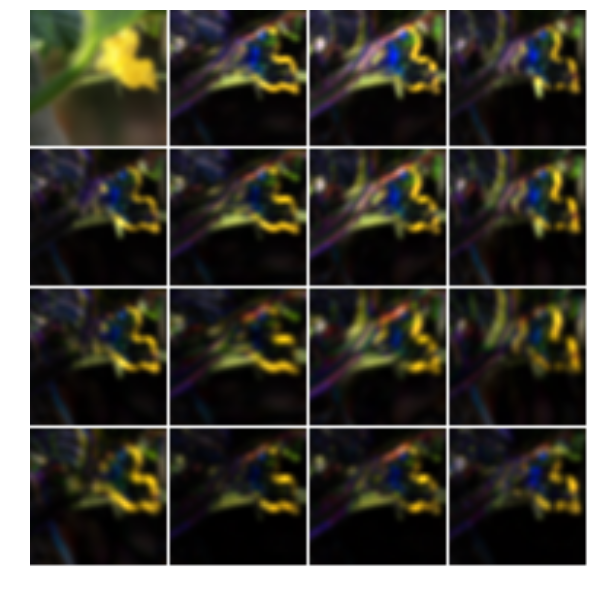

In [62]:
plt.figure(figsize=(10,10))
show_output(net)

# Prepare input

In [26]:
train_data_path = os.path.join(plant_clef_root, 'data', 'train.txt')
test_data_path = os.path.join(plant_clef_root, 'data', 'test.txt')

train_output_folder = os.path.join(plant_clef_root, 'data', 'train_scat')
test_output_folder = os.path.join(plant_clef_root, 'data', 'test_scat')

In [26]:
redo_scattnet = False
if redo_scattnet:
    logger.info('Started Generating scattering coefficients')

    for img_list, out_folder in [(train_data_path, train_output_folder), (test_data_path, test_output_folder)]:

        images = !cat $img_list
        transform_param = dict(mirror=False, crop_size=227)
        species_data, species_label = L.ImageData(transform_param=transform_param,
                                                  source=train_data_path,
                                                  batch_size=1,
                                                  new_height=256,
                                                  new_width=256,
                                                  ntop=2)

        if 'net' in locals():
            del net
        net = scatnet(data=species_data, 
                      scales=scales, 
                      max_order=max_order, 
                      nangles=nangles, 
                      filter_size_factor=filter_size_factor)
        nimages = len(images)
        t0 = time.time()
        for i in range(nimages):
            net.forward()
            output = net.blobs['output'].data
            base = os.path.basename(images[i].split()[0])
            file_name = os.path.splitext(base)[0] + '.scat'
            file_path = os.path.join(out_folder, file_name)
            output.tofile(file_path)

            if not i%100:
                logger.info("%6i/%6i. %.1f img/sec" % (1+i, nimages, (1+i)/(time.time()-t0)))


    logger.info('Finished')

In [71]:
mean_output = os.path.join(plant_clef_root, 'scat_mean.npy')
var_output = os.path.join(plant_clef_root, 'scat_var.npy')

scat_files = !ls /home/ffw/workspace/plantCLEF/data/train_scat/*.scat
nfiles = len(scat_files)


redo_mean_computation = False

if redo_mean_computation: 
    logger.info("Generating mean and var vectors")
    t0 = time.time()
    
    sum_coeff = np.zeros((len(scat_files), shape[1]))
    
    for i, file_path in enumerate(scat_files):
        data = np.fromfile(file_path, dtype=dtype).reshape(shape)    
        data = np.power(data, 2)
        sum_value = np.sum(np.sum(data,2),2)
        sum_value = np.sqrt(sum_value)[0]
        
        sum_coeff[i,:] = sum_value
        
        if not i%1000:
            logger.info("%6i/%6i. %.1f img/sec" % (1+i, nfiles, (1+i)/(time.time()-t0)))
        
    mean_coeff = np.mean(sum_coeff,axis=0)
    var_coeff = np.var(sum_coeff,axis=0)
    scipy.save(mean_output, mean_coeff)
    scipy.save(var_output, var_coeff)



In [31]:
plt.semilogy(sorted(mean_coeff))

TypeError: 'numpy.float32' object is not iterable

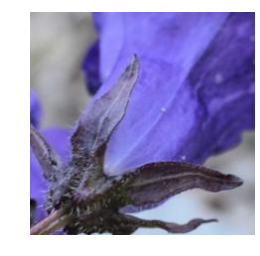

In [236]:
plt.imshow(np.squeeze(1-net.blobs['data'].data.transpose([2,3,1,0])[:,:,[2,1,0]]))
plt.axis('off');
plt.show();

#img = scipy.misc.imread(images[i].split()[0])
#plt.imshow(img[:,:,:])
#plt.show()

In [ ]:

net = scatnet(data=species_data, scales=scales, max_order=max_order, nangles=nangles, filter_size_factor=filter_size_factor)

# Experiment with scat coefficients

In [35]:
output.shape
# (375, 47, 47)

NameError: name 'output' is not defined

In [10]:
120000*np.prod((375, 47, 47)) * 1 * 2**-30

92.578120529651642

In [42]:
60*4/24.

10.0